# Bootstrap used for Error estimation

Given a best guess at the parameters $\phi$ and $\delta t$ use resampling with replacement of the seismic data to bootstrap the covariance matrix.

From this we can calculate distributions of the eigenvectors, eigenvalues, and pearson correlation coefficients, which can be used to estimate the errors in the source polarisation and the splitting parameters (according to the Silver and Chan method, as well as the cross-correlation method).

How to chose the best guess parameters?  One idea would be to run the grid search and use the parameters that minimise $\lambda_2$, or to chose the parameters that maximise $\rho$.  If each approach is equally valid then some kind of joint solution may be derived by 

In [1]:
%load_ext autoreload
%autoreload 2

import splitwavepy as sw

import numpy as np
import matplotlib.pyplot as plt

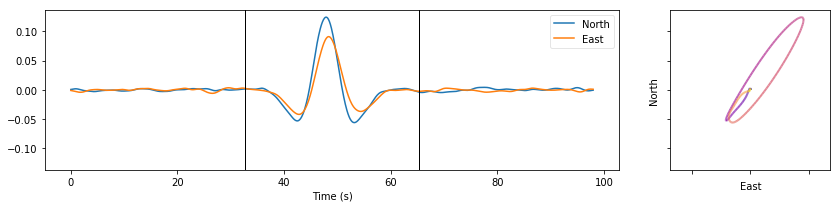

In [2]:
a = sw.SplitWave(split=(30,2), noise=0.01, pol=40).Py()
a._data.plot()
x = a._data.x
y = a._data.y

In [3]:
from scipy.stats import gaussian_kde

def wrap_unsplit(x, y, rotate, dt, delta):
    x, y = sw.core.core.rotate(x, y, rotate)
    shift = sw.core.core.time2samps(dt, delta)
    x = np.roll(x, shift)
#     x, y = sw.core.core.rotate(x, y, -rotate)
    return x, y


def bootcov(x, y, n=2000):
    """Resample x, y data and return n bootstrap covariance matrices."""
    
    # prep data with taper to window, rotate, 
    # and lag with wrap around (to replicate process in fourier domain)    
    bscov = np.empty((n, 2, 2))
    
    for ii in range(n):
        bsx, bsy = sw.core.core.bootstrap_resamp(x, y)
        bscov[ii] = sw.core.core.cov2d(bsx, bsy)
        
    return bscov

def get_kdes(bscov, pol=None):
    """Generate KDEs of rho, lam1/lam2, and spol (unless pol is specified).
    
    Uses the eigenvalue  method unless pol is specified,
    in which case will use the transverse minimisation method. """
    
    stdx = np.sqrt(bscov[:, 0, 0])
    stdy = np.sqrt(bscov[:, 1, 1])
    rho = bscov[:, 0, 1] / (stdx * stdy)
    r_kde = gaussian_kde(rho)
    
    if pol is None:
        # use eigenvector method.
        evals, evecs = np.linalg.eigh(bscov)
        rat = evals[:,1]/evals[:,0]
        spol = (np.rad2deg(np.arctan2(evecs[:,1,1], evecs[:,0,1]))+3690)%180-90
        rat_kde = gaussian_kde(rat)
        spol_kde = gaussian_kde(spol)
        return r_kde, rat_kde, spol_kde
    else:
        # use transverse min method
        rat = bscov[:,0,0]/bscov[:,1,1]
        rat_kde = gaussian_kde(rat)
        return r_kde, rat_kde
    

    
    
        
        

# def bscov2(bscov, pol=None):
    
        
        
        

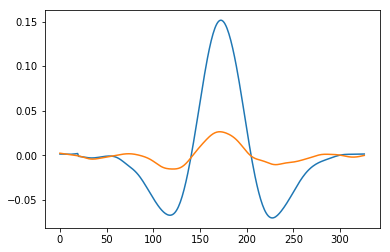

In [4]:
chp = a._data.chop()
x, y = chp.x, chp.y
sx, sy = wrap_unsplit(x, y, 30, 2, a._data._delta)
plt.plot(sx)
plt.plot(sy)
plt.show()

In [5]:
# check to see if result from my cov2d function gives same result
# as obtained using the gridcovfreq algorithm

mycov = sw.core.core.cov2d(sx, sy)
print(mycov)

gcov = sw.core.core.gridcovfreq(sx, sy)
rscov = sw.core.core.cov_reshape(gcov)
rscov[0][0]

np.allclose(mycov, rscov[0,0])

# what if we shift by a sample or n?
n = 10
mycov = sw.core.core.cov2d(np.roll(sx,n), sy)
print(mycov)

np.allclose(rscov[n,0], mycov)


[[3.04509415e-03 5.25910063e-04]
 [5.25910063e-04 9.56295194e-05]]
[[3.04509415e-03 4.76279645e-04]
 [4.76279645e-04 9.56295194e-05]]


True

In [6]:
bcov = bootcov(sx, sy, n=2000)
evals, evecs = np.linalg.eigh(bcov)

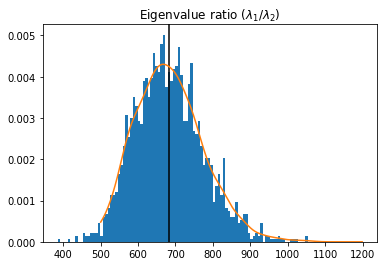

In [7]:
plt.close()
rat = evals[:,1]/evals[:,0]
plt.hist(rat, bins=100, density=True)
plt.axvline(np.mean(rat), color='k')
plt.title('Eigenvalue ratio ($\lambda_1/\lambda_2$)')

kde = gaussian_kde(rat)
plt.plot(np.arange(500,1200),kde.pdf(np.arange(500,1200)))


plt.show()

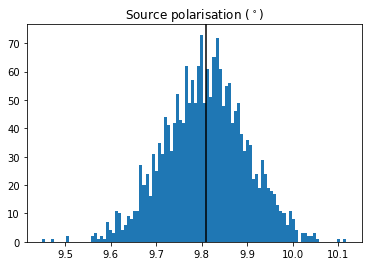

In [8]:

# evec1 = evecs[0,:,1]
# (np.rad2deg(np.arctan2(evec1[1],evec1[0]))+180)
angs = (np.rad2deg(np.arctan2(evecs[:,1,1], evecs[:,0,1]))+3690)%180-90
plt.hist(angs, bins=100)
plt.axvline(np.mean(angs), color='k')
plt.title('Source polarisation ($^\circ$)')
plt.show()

In [9]:
def covmap2rho(cov):
    stdx = np.sqrt(cov[:, 0, 0])
    stdy = np.sqrt(cov[:, 1, 1])
    rho = cov[:, 0, 1] / (stdx * stdy)
    return rho

In [10]:
rho = covmap2rho(b)
plt.hist(rho, bins=100)
plt.axvline(np.mean(rho), color='k')
plt.title('Pearson r')
plt.show()

NameError: name 'b' is not defined

In [ ]:
from scipy.stats import gaussian_kde

In [ ]:
kde.integrate_kde?

In [ ]:
%timeit kde.integrate_box_1d(0,800)


In [ ]:
bcov = bootcov(sx, sy, n=2000)
rhokde, ratkde, spolkde = get_kdes(bcov)
fig, axarr = plt.subplots(3)
# axarr[0].hist(rhokde, bins=50, density=True)
# axarr[1].hist(ratkde, bins=50, density=True)
# axarr[2].hist(ratkde, bins=50, density=True)

# rho kde
rho_x = np.linspace(0.97,1,200)
axarr[0].plot(rho_x, rhokde.pdf(rho_x))
# rat_x
# azarr[1].plot()
# axarr[1].pl
plt.show()

In [ ]:
a.sc.psurf()

In [ ]:
a.sc.data.

In [ ]:
# inspect data

a._data.rotateto(0).chop().

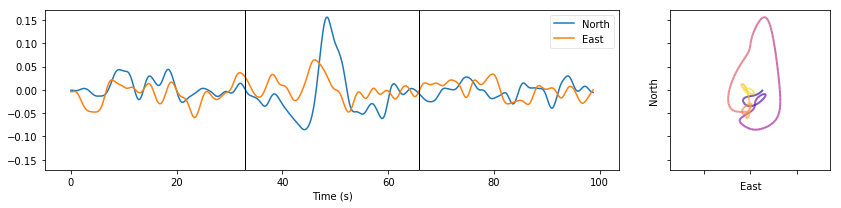

In [30]:
a = sw.SplitWave(split=(30,1.2), noise=0.1)
a.plot()

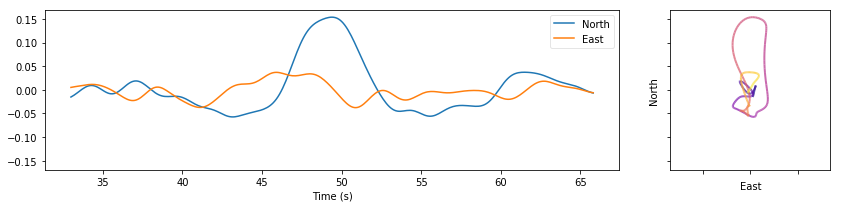

In [28]:
b = a.chop()
b.plot()

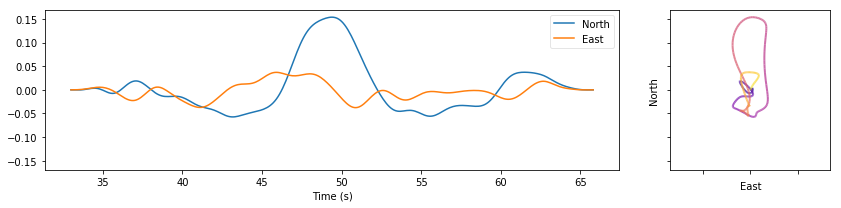

In [29]:
c = b.taper(.2)
c.plot()

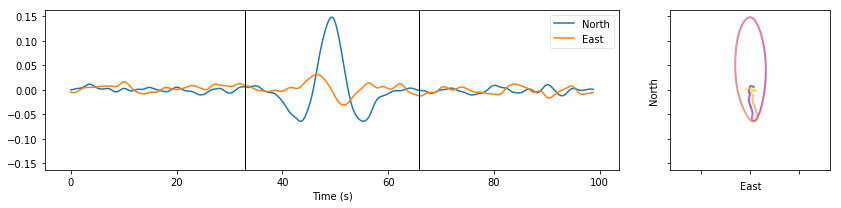

In [15]:
a = sw.SplitWave(split=(30,1.2), noise=0.03)
a.plot()


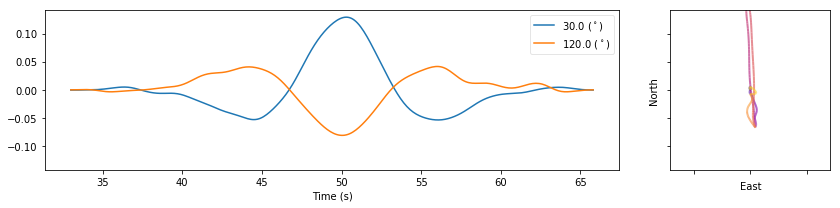

In [16]:
b = a._wrap_unsplit(30, 1.2)
b.plot()

In [101]:
a = sw.SplitWave(split=(30,1.2), noise=0.02).Py()

In [102]:
r_kde, rat_kde, spol_kde = a._bootstrap_kdes(30,1.2)

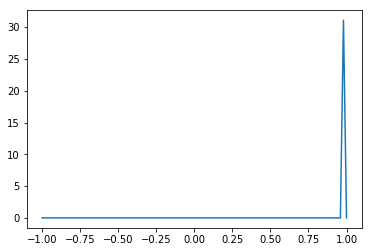

In [103]:
x = np.linspace(-1,1.0,100)
plt.plot(x, r_kde(x))
plt.show()

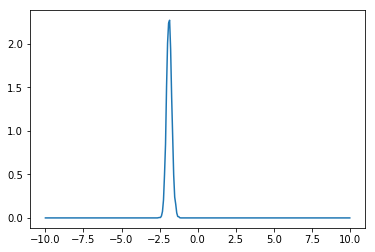

In [105]:
x = np.linspace(-10,10,300)
plt.plot(x, spol_kde(x))
plt.show()

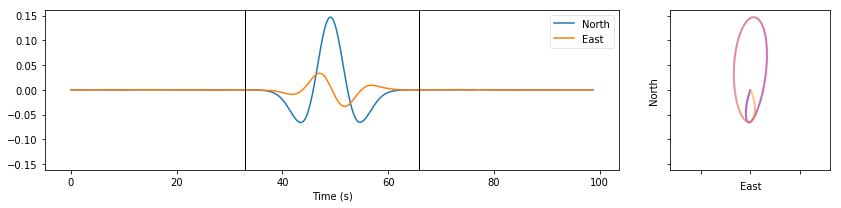

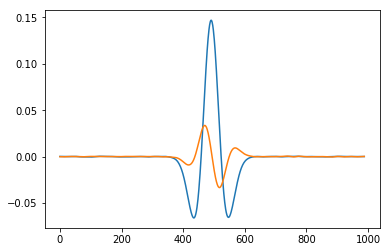

array([[ 1., -0.],
       [ 0.,  1.]])

In [106]:
a = sw.SplitWave(split=(30,1.2)).Py()
a.data.plot()
plt.plot(a.data.x)
plt.plot(a.data.y)
plt.show()
a.data._vecs

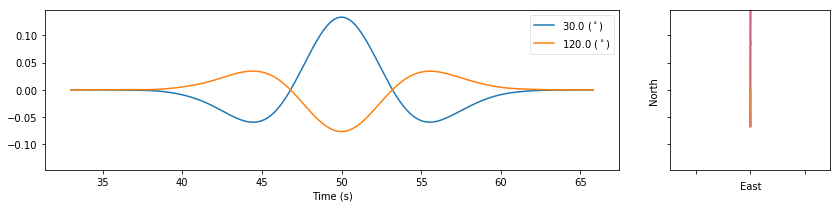

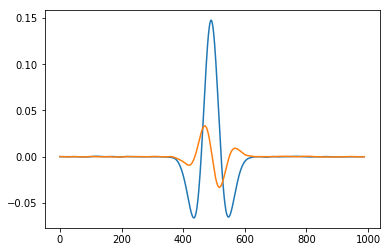

array([[ 1., -0.],
       [ 0.,  1.]])

In [95]:
b = a.data._wrap_unsplit(30, 1.2)
b.plot()
plt.plot(a.data.x)
plt.plot(a.data.y)
plt.show()
a.data._vecs

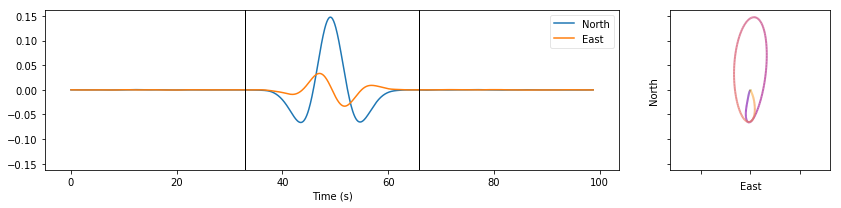

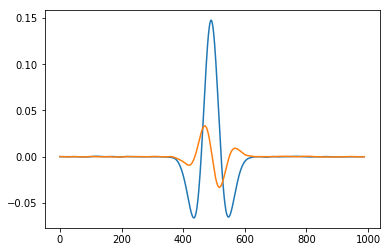

In [96]:
a.data.plot()
plt.plot(a.data.x)
plt.plot(a.data.y)
plt.show()